# Ground-roll attenuation model with attention

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import sys
sys.path.append('../..')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from seismicpro.batchflow import Pipeline, V, B, L, I, W

from seismicpro.batchflow.batchflow.models.tf import UNet, VGG7
from seismicpro.batchflow.batchflow.models.tf.nn.activations import h_sigmoid

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import attention_loss_gauss


from Ground_Roll.src.unet_att2_params import UnetAttParams

%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


In [2]:
# import os
# import sys
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# sys.path.append('../../..')

# from seismicpro.batchflow import Pipeline, V, B, L, I, W
# from seismicpro.batchflow.models.tf.layers import conv_block
# from seismicpro.batchflow.models.tf import UNet

# from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
#                             seismic_plot, spectrum_plot, merge_segy_files)
# from seismicpro.models import UnetAttGauss1, attention_loss_gauss, FieldMetrics

# %env CUDA_VISIBLE_DEVICES=7

Index dataset

In [3]:
!ls /notebooks/data/H1_WZ

1_NA-gr_input_DN01.sgy	      1_NA-gr_output_DN03.sgy
1_NA-gr_input_DN01_norm2.sgy  1_NA-gr_output_DN03_norm2.sgy


In [4]:
path_raw = '/notebooks/data/H1_WZ/1_NA-gr_input_DN01_norm2.sgy'
path_lift = '/notebooks/data/H1_WZ/1_NA-gr_output_DN03_norm2.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,326,1512,1,/notebooks/data/H1_WZ/1_NA-gr_input_DN01_norm2...,1,/notebooks/data/H1_WZ/1_NA-gr_output_DN03_norm...
111906,3307,323,1062,/notebooks/data/H1_WZ/1_NA-gr_input_DN01_norm2...,1062,/notebooks/data/H1_WZ/1_NA-gr_output_DN03_norm...
111906,3306,1288,1061,/notebooks/data/H1_WZ/1_NA-gr_input_DN01_norm2...,1061,/notebooks/data/H1_WZ/1_NA-gr_output_DN03_norm...
111906,3306,398,1060,/notebooks/data/H1_WZ/1_NA-gr_input_DN01_norm2...,1060,/notebooks/data/H1_WZ/1_NA-gr_output_DN03_norm...
111906,3305,1161,1059,/notebooks/data/H1_WZ/1_NA-gr_input_DN01_norm2...,1059,/notebooks/data/H1_WZ/1_NA-gr_output_DN03_norm...


Reserve 10 field records for model training:

In [5]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = SeismicDataset(tindex)

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask.

Define the model config and loss function:

In [7]:
model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
                   lift={'name': 'targets', 'shape': (3000, 1)}),
    'loss': (attention_loss_gauss, {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.0001}),
    'common/data_format': 'channels_last',
    'common/main_base_class': UNet,
    'common/att_base_class': VGG7,
    'body': {
        'main': {
            'encoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128],
                                   kernel_size=[7, 5, 5, 5],
                                   activation=tf.nn.elu),
            'encoder/downsample': dict(layout='pd',
                                       pool_size=2,
                                       pool_strides=2,
                                       dropout_rate=0.05),
            'embedding': dict(layout='ca ca', kernel_size=5, filters=256),
            'decoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128][::-1],
                                   kernel_size=[7, 5, 5, 5][::-1],
                                   activation=tf.nn.elu),
            'decoder/upsample': dict(layout='tad',
                                     kernel_size=[7, 5, 5, 5][::-1],
                                     strides=2,
                                     dropout_rate=0.05,
                                     activation=tf.nn.elu, ),
        },
        'att': {},
    },
    'head': {
        'main': dict(layout='c', filters=1, units=1),
        'att': dict(layout='fa', units=2, activation=h_sigmoid),
    },

    'train_steps': {'step_main': {'scope': 'main_branch'},
                 'step_attention': {'scope': 'attention_branch'}}
}

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.0001

Loss balance: 0.05

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 2.

Define a train pipeline:

In [8]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw), 'lift': exp_stack(batch.lift)}

train_pipeline = (Pipeline()
                  .init_model('static', UnetAttParams, name='unet', config=model_config)
                  .init_variable('loss', default=list())
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .train_model('unet', make_data=make_data, fetches='loss_step_main', save_to=V('loss', 'a'))
                 )

Specify a dataset for model training:

In [9]:
train_pipeline = train_pipeline << train_set

Run model training for 3 epochs with batch size of 64:

In [10]:
batch_size = 64

train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=2, drop_last=True,
                                    shuffle=True, bar=True, bar_desc=W(V('loss')[-1].format('Current loss is: {:7.7}')))

Current loss is: 0.08031929: 100%|██████████| 534/534 [12:18<00:00,  1.38s/it]


Plot loss function decay:

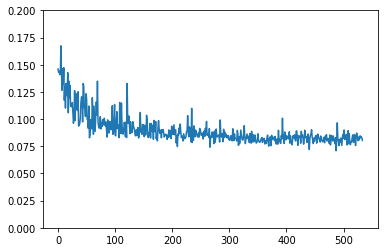

In [11]:
loss = np.array(train_pipeline.get_variable('loss'))
plt.plot(loss)
plt.ylim(0, 0.2)
plt.show()

In [12]:
from scipy import stats
stats.describe(loss[-100:])

DescribeResult(nobs=100, minmax=(0.07090996, 0.09655254), mean=0.08182036, variance=1.4268785e-05, skewness=0.3064265847206116, kurtosis=1.919534154326504)

In [13]:
fetches=['out_lift', 'mask'] #, 'sigmoid_center']

test_pipeline = (Pipeline()
                 .import_model('unet', train_pipeline)
                 .init_variable('res', default=list())
                 .init_variable('raw', default=list())
                 .init_variable('lift', default=list())
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .update_variable('raw', B('raw'), mode='a')
                 .update_variable('lift', B('lift'), mode='a')
                 .predict_model('unet', make_data=make_data, fetches=fetches, save_to=V('res', 'a')))


def check_res(i, test_pipeline, cv=0.1):  
    test_set = SeismicDataset(TraceIndex(index.create_subset(index.indices[i: i+1])))
    test_pipeline = test_pipeline << test_set
    test_pipeline = test_pipeline.run(batch_size=500, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)
    raw = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('raw')])
    lift = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('lift')])
    out = np.squeeze(np.vstack([x[0] for x in test_pipeline.get_variable('res')]))
    att = np.squeeze(np.vstack([x[1] for x in test_pipeline.get_variable('res')]))
#     sigm_center = np.vstack([x[2] for x in test_pipeline.get_variable('res')])
    seismic_plot([raw, att, out, out - raw, out -lift],
             figsize=(19, 7), names=['RAW', 'NOISE MASK', 'OUTPUT', 'OUTPUT - RAW', 'out-lift'],
             cmap='gray', vmin=-cv, vmax=cv)
    
    return raw, att, lift, out

Run test pipeline:

100%|██████████| 4/4 [00:08<00:00,  2.34s/it]


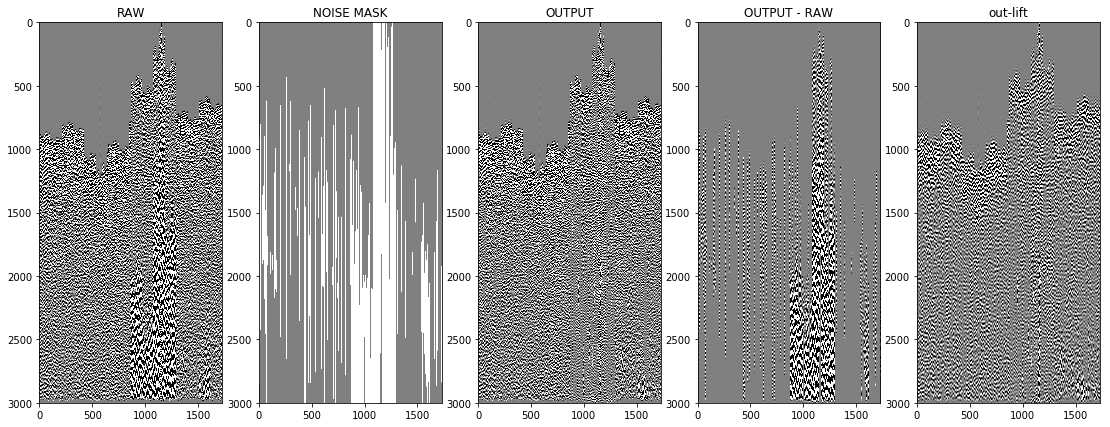

In [14]:
i = 20
raw, att, lift, out = check_res(i, test_pipeline)

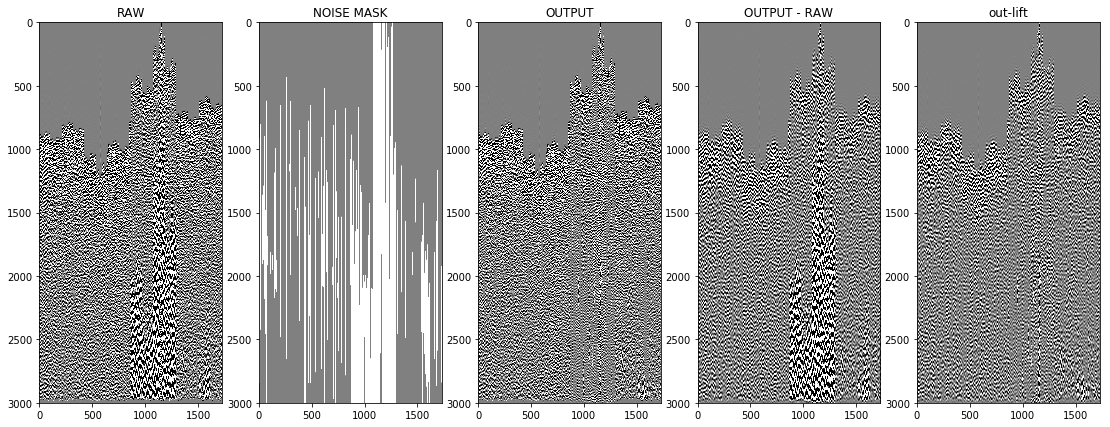

In [17]:
seismic_plot([raw, att, out, raw - lift, out -lift],
             figsize=(19, 7), names=['RAW', 'NOISE MASK', 'OUTPUT', 'OUTPUT - RAW', 'out-lift'],
             cmap='gray', vmin=-0.1, vmax=0.1)

In [ ]:
plt.plot(np.vstack([att[500], att_raw[500], (raw[500])]).T, alpha=0.7);

In [ ]:
plt.plot(np.vstack([att[1200], att_raw[1200], (raw[1200])]).T, alpha=0.7);

In [ ]:
seismic_plot([raw, att_raw, att], xlim=(800, 1200),
             figsize=(19, 7), names=['raw','Noise Raw', 'NOISE MASK'],
             cmap='gray', vmin=-1, vmax=1)

In [ ]:
seismic_plot([raw, att_raw, att], xlim=(800, 1200), ylim=(850, 950),
             figsize=(19, 7), names=['raw','Noise Raw', 'NOISE MASK'],
             cmap='gray', vmin=-0.1, vmax=1)

In [ ]:
seismic_plot([raw, att_raw, att], xlim=(500, 600), ylim=(2000, 2100),
             figsize=(19, 7), names=['raw','Noise Raw', 'NOISE MASK'],
             cmap='gray', vmin=-0.1, vmax=1)

In [ ]:
model_config

100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


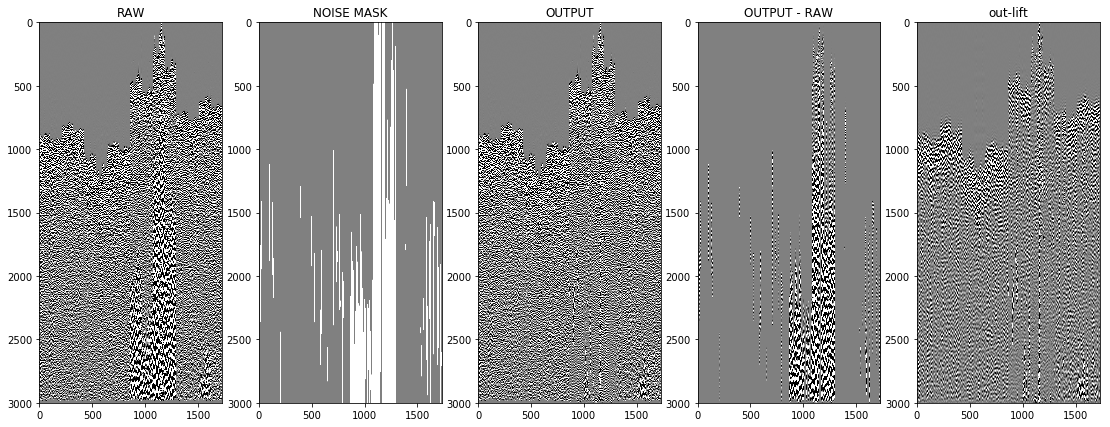

In [15]:
i = 21
check_res(i, test_pipeline);